In [1]:
import gym
import numpy as np
from gym import spaces
#import tensorflow as tf
#from tensorflow.keras import layers
from collections import deque
from dd_class import Dragodinde
from dd_class import Elevage
import random
import time

In [2]:
class ElevageEnv(gym.Env):
    def __init__(self, elevage):
        super(ElevageEnv, self).__init__()
        self.elevage = elevage

        # Define the action and observation space
        self.action_space = spaces.Discrete(len(elevage.get_dragodindes()) ** 2)
        self.observation_space = spaces.Box(
            low=0, high=10, shape=(len(elevage.get_dragodindes()), 4), dtype=np.float32)

        self.state = self._get_observation()
        self.interrested_dd = self._get_interested_dd()
        self.current_step = 0
        self.max_steps = 1000
        self.max_generations = 10
        self.actual_generation = 1

    def _get_observation(self):
        """
        Returns the current observation of the environment.
        The observation could be the current state of all dragodindes in the elevage.
        Each dragodinde might have features such as gender, color, generation, etc.
        """
        obs = []
        actual_generations = 1
        for dragodinde in self.elevage.dragodindes:
            generation = dragodinde.get_generation()
            obs.append([
                dragodinde.get_id(), generation, self._encode_gender(dragodinde.get_sex()), self._encode_color(dragodinde.get_color())
            ])
            if generation > actual_generations :
                actual_generations = generation

        return np.array(obs, dtype=np.float32), actual_generations

    def _get_interested_dd(self) :
        """
        Return an dict
        key (int) : generation
        value (list(str)) : list of dd color need to crossing for have this generation
        """

        interreseted_dd = {2 : ["Dorée", "Amande", "Rousse"],
                           3 : ["Amande et Rousse","Amande et Dorée", "Dorée et Rousse"],
                           4 : ["Indigo","Ebène"],
                           5 : ["Amande et Rousse","Ebène et Indigo", "Dorée et Rousse"],
                           6 : ["Pourpre","Orchidée"],
                           7 : ["Indigo et Pourpre","Ebène et Orchidée", "Orchidée et Pourpre"],
                           8 : ["Ivoire","Turquoise"],
                           9 : ["Ivoire et Pourpre","Ivoire et Turquoise", "Turquoise et Orchidée"],
                           10 : ["Emeraude", "Prune"]
                           }
        return interreseted_dd

    def _encode_gender(self, gender):
        """Encodes gender as a numerical value."""
        return 1 if gender == "M" else 0

    def _encode_color(self, color):
        color_encoding = {
            "Rousse": 0,
            "Amande": 1,
            "Dorée": 2,
            "Rousse et Amande": 3,
            "Rousse et Dorée": 4,
            "Amande et Dorée": 5,
            "Indigo": 6,
            "Ebène": 7,
            "Rousse et Indigo": 8,
            "Rousse et Ebène": 9,
            "Amande et Indigo": 10,
            "Amande et Ebène": 11,
            "Dorée et Indigo": 12,
            "Dorée et Ebène": 13,
            "Indigo et Ebène": 14,
            "Pourpre": 15,
            "Orchidée": 16,
            "Pourpre et Rousse": 17,
            "Orchidée et Rousse": 18,
            "Amande et Pourpre": 19,
            "Amande et Orchidée": 20,
            "Dorée et Pourpre": 21,
            "Dorée et Orchidée": 22,
            "Indigo et Pourpre": 23,
            "Indigo et Orchidée": 24,
            "Ebène et Pourpre": 25,
            "Ebène et Orchidée": 26,
            "Pourpre et Orchidée": 27,
            "Ivoire": 28,
            "Turquoise": 29,
            "Ivoire et Rousse": 30,
            "Turquoise et Rousse": 31,
            "Amande et Ivoire": 32,
            "Amande et Turquoise": 33,
            "Dorée et Ivoire": 34,
            "Dorée et Turquoise": 35,
            "Indigo et Ivoire": 36,
            "Indigo et Turquoise": 37,
            "Ebène et Ivoire": 38,
            "Ebène et Turquoise": 39,
            "Pourpre et Ivoire": 40,
            "Turquoise et Pourpre": 41,
            "Ivoire et Orchidée": 42,
            "Turquoise et Orchidée": 43,
            "Ivoire et Turquoise": 44,
            "Emeraude": 45,
            "Prune": 46,
            "Rousse et Emeraude": 47,
            "Rousse et Prune": 48,
            "Amande et Emeraude": 49,
            "Amande et Prune": 50,
            "Dorée et Emeraude": 51,
            "Dorée et Prune": 52,
            "Indigo et Emeraude": 53,
            "Indigo et Prune": 54,
            "Ebène et Emeraude": 55,
            "Ebène et Prune": 56,
            "Pourpre et Emeraude": 57,
            "Pourpre et Prune": 58,
            "Orchidée et Emeraude": 59,
            "Orchidée et Prune": 60,
            "Ivoire et Emeraude": 61,
            "Ivoire et Prune": 62,
            "Turquoise et Emeraude": 63,
            "Turquoise et Prune": 64
        }

        return color_encoding.get(color, -1)  # Return -1 if the color is not found

    def step(self, action):
        """
        Apply the action and return the next state, reward, done, and info.
        """
        assert self.action_space.contains(action)
        self.current_step += 1

        # Define the logic for updating the state based on the action
        # For now, let's assume action is an index to select two dragodindes for breeding
        dragodinde_1_id = action // len(self.elevage.dragodindes)
        dragodinde_2_id = action % len(self.elevage.dragodindes)

        breeding = self._breed_dragodindes(dragodinde_1_id, dragodinde_2_id)

        # Calculate the reward based on the action
        next_state, reward, done, info = self._calculate_reward(action, breeding)

        if self.current_step >= self.max_steps:
            done = True

        self.state, self.actual_generation = self._get_observation()

        return self.state, reward, done, info

    def _breed_dragodindes(self, idx1, idx2):
        """
        Simulates the breeding of two dragodindes and updates the elevage state.
        This is a placeholder method and should be replaced with actual breeding logic.
        """
        if idx1 != idx2 :  # Ensure that the same dragodinde is not breeding with itself
            parent_1 = self.elevage.dragodindes[idx1]
            parent_2 = self.elevage.dragodindes[idx2]

            if parent_1.get_sex() != parent_2.get_sex():
              # Implement actual breeding logic here and update self.elevage.dragodindes
              # For simplicity, assume a new dragodinde is created with generation + 1
              new_dragodinde, _ = self.elevage.accouplement_naissance(parent_1, parent_2)
              self.elevage.dragodindes.append(new_dragodinde)
              return True

        return False

    def _calculate_reward(self, action, breeding):
        """
        Calculates the reward based on the action and the current state of the environment.
        """
        reward = 0
        done = False
        info = {}

        if self.actual_generation == self.max_generations:
            done = True
            reward = 1000  # High reward for completing the maximum generations

        #elif action == self.interrested_dd[self.generation] :
        #    reward = 10  # Positive reward for purify dd that are implicated in the new generation

        elif action > self.actual_generation:
            reward = 100  # Smaller reward for valid actions advancing the generation

        elif action < self.actual_generation - 2:
            reward = -100  # Penalty for regressing too far back in generations

        if not breeding :
            reward = -10  # Penalty for not breeding

        return self.state, reward, done, info

    def reset(self):
        """
        Resets the environment to an initial state and returns the initial observation.
        """
        self.current_step = 0
        self.actual_generation = 1
        self.elevage = self.create_elevage()
        self.state, _ = self._get_observation()
        return self.state

    def render(self, mode='human'):
        """
        Renders the current state of the environment.
        """
        print(f"Generation: {self.actual_generation}")

    def create_elevage(self):
        """
        Initializes a new Elevage with a predefined set of dragodindes.
        """
        dragodindes_data = [
            (1, "M", "Rousse", 1),
            (2, "F", "Rousse", 1),
            (3, "M", "Amande", 1),
            (4, "F", "Amande", 1),
            (5, "M", "Dorée", 1),
            (6, "F", "Dorée", 1)
        ]

        list_dd = []
        for id, gender, color, generation in dragodindes_data:
            dragodinde = Dragodinde(id, gender, color, generation)
            list_dd.append(dragodinde)

        return Elevage(list_dd)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(16, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [3]:
env = ElevageEnv(ElevageEnv.create_elevage(ElevageEnv))
state_size = np.prod(env.observation_space.shape)  # Calculate state_size based on observation space
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
batch_size = 32

episodes = 100

for e in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])  # Reshape initial state

    # Try 1000 croissing
    for time in range(1000):
        env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10

        # Reshape next_state dynamically based on its actual size
        next_state = np.reshape(next_state, [1, -1])  
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            print(f"Episode {e+1}/{episodes}, Score: {time}")
            break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

agent.save("DQNA_elevage.h5")

NameError: name 'tf' is not defined

In [34]:
class Models :
    def __init__(self) :
        self.elevage = self.create_elevage()
        self.interred_dd = {2 : ["Dorée", "Amande", "Rousse"],
                            3 : ["Amande et Rousse","Amande et Dorée", "Dorée et Rousse"],
                            4 : ["Indigo","Ebène"],
                            5 : ["Amande et Rousse","Ebène et Indigo", "Dorée et Rousse"],
                            6 : ["Pourpre","Orchidée"],
                            7 : ["Indigo et Pourpre","Ebène et Orchidée", "Orchidée et Pourpre"],
                            8 : ["Ivoire","Turquoise"],
                            9 : ["Ivoire et Pourpre","Ivoire et Turquoise", "Turquoise et Orchidée"],
                            10 : ["Emeraude", "Prune"]
                            }

    def __str__(self) :
        return (f"{self.elevage}")
    
    def get_length_elevage(self) :
        return len(self.elevage.get_dragodindes())
    
    def get_better_generation(self) :
        better_generation = 1
        for dragodinde in self.elevage.get_dragodindes() :
            generation = dragodinde.get_generation()
            if generation > better_generation :
                better_generation = generation
        
        return better_generation

    def get_dd_better_generation(self, dragodindes) :
        better_generation = 1
        list_better_dd = []
        for idx, dragodinde in enumerate(dragodindes) :
            generation  = dragodinde.get_generation()
            if generation > better_generation :
                list_better_dd = []
                better_generation = generation
                list_better_dd.append(dragodindes[idx])
            elif generation == better_generation :
                list_better_dd.append(dragodindes[idx])

        return list_better_dd

    def create_elevage(self):

        dragodindes_data = [
            (1, "M", "Rousse", 1),
            (2, "F", "Rousse", 1),
            (3, "M", "Amande", 1),
            (4, "F", "Amande", 1),
            (5, "M", "Dorée", 1),
            (6, "F", "Dorée", 1)
        ]

        list_dd = []
        for id, gender, color, generation in dragodindes_data:
            dragodinde = Dragodinde(id, gender, color, generation)
            list_dd.append(dragodinde)

        return Elevage(list_dd)
    
    def strategy_random_crosing(self):
        males = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "M"]
        females = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "F"]

        if not males or not females:
            raise ValueError("No suitable pairs for crossing.")

        male = random.choice(males)
        female = random.choice(females)

        # Assuming accouplement_naissance is a method that performs crossing and returns probabilities
        nouvelle_dd, _ = self.elevage.accouplement_naissance(male, female)

        return nouvelle_dd
    
    def strategy_crosing_better_gen(self):
        males = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "M"]
        females = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "F"]

        if not males or not females:
            raise ValueError("No suitable pairs for crossing.")

        # Take the best generation
        list_better_males = self.get_dd_better_generation(males)
        list_better_females = self.get_dd_better_generation(females)

        if list_better_males[0].get_generation() > list_better_females[0].get_generation():
            male = random.choice(males)
            female = random.choice(list_better_females)
        
        elif list_better_males[0].get_generation() <= list_better_females[0].get_generation():
            male = random.choice(list_better_males)
            female = random.choice(females)

        nouvelle_dd, _ = self.elevage.accouplement_naissance(male, female)
        return nouvelle_dd

    def is_in_every_sublist(self, lst, target):
        for item in lst:
            if isinstance(item, list):
                if not self.is_in_every_sublist(item, target):  # Recursively check sublists
                    return False
            elif item != target:
                return False
        return True
    
    # List the quality of purety of a list of dd
    def check_purity(self, list_dd : list, purity=3) -> list :
        """
        Purity : Thresold of purity (same color) quality
        (0 : only ind is pur, 1 : ind + parent, ...)
        """
        list_pur = []        
        for dd in list_dd :
            list_color_dd = dd.get_arbre_genealogique().get_genealogie(purity)
            color_ind = dd.get_color()

            # Case no genealogie or not all generation present
            if not list_color_dd or self.is_in_every_sublist(list_color_dd ,color_ind) : 
                list_pur.append(dd)

        return list_pur
    
    def need_to_create(self, color_combo, males, females) :
        if color_combo in males and color_combo in females : 
            # High generation dd are find
            return False
        else :
            return True

    def indentify_dd(self, males, females, list_pure_males, list_pure_females):
        target_generation = 10  # The final generation we want to achieve
        male = None
        female = None

        # Start by checking from the last generation that needs to be achieved
        for gen in range(target_generation, 1, -1):
            required_color_combinations = self.interred_dd[gen]
            #print("required_color_combinations : ", required_color_combinations)

            # Try to find a pure pair that can create the desired generation
            for color_combo in required_color_combinations:
                # Decide if purification or creation are archive
                unpur_males = list(males ^ list_pure_males)
                unpur_females = list(females ^ list_pure_females)
                if self.need_to_create(color_combo, unpur_males, unpur_females) :
                    male, female = self.find_to_create(color_combo, list_pure_males, list_pure_females)
                    if male and female:
                        return male, female
                else : 
                    male, female = self.find_to_purify(color_combo, males, females)
                    if male and female:
                        return male, female

        raise ValueError("male and female not paired in indentify_dd()")

    def find_to_create(self, color_combo, list_males, list_females):
        for m in list_males:
            if m.get_color() in color_combo:
                for f in list_females:
                    # print("color_combo :", color_combo)
                    # print("m.get_colors() :", m.get_color())
                    # print("f.get_colors() :", f.get_color())

                    if f.get_color() in color_combo and f.get_color() != m.get_color() :
                        return m, f
        return None, None
    
    def find_to_purify(self, color_combo, list_males, list_females):
        for m in list_males:
            if m.get_color() == color_combo:
                for f in list_females:
                    print("color_combo :", color_combo)
                    # print("m.get_colors() :", m.get_color())
                    # print("f.get_colors() :", f.get_color())

                    if f.get_color() == color_combo:
                        return m, f
        return None, None

    def strategy_select_and_purify(self) :
        # Intuition:
        # Identify dd that need to be crossed to create a 10th-generation dd
        # Identify dd that need to be purified (while the n-1 generation dd is available)
        # Purify and lock the selected dd (M and F)
        # While a selected dd is identified (color) and gen n - 1 is purified
        # Do crossing / purification step   

        males = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "M"]
        females = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "F"]
        
        if not males or not females:
            raise ValueError("No suitable pairs for crossing.")
        
        # check if male and female are pure 
        list_pure_males = self.check_purity(males)
        list_pure_females = self.check_purity(females)

        # Identify dd that need to be created of purify 
        male, female = self.indentify_dd(males, females, list_pure_males, list_pure_females)
        #print("male, female : ", male.get_color(), female.get_color())

        # Crossing each other
        nouvelle_dd, _ = self.elevage.accouplement_naissance(male, female)
        print("new born : ", nouvelle_dd.get_color())
        return nouvelle_dd
    
import matplotlib.pyplot as plt
 
def plot_simlation(list_simulation) : 
    x_values = list(range(len(list_simulation)))

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plotting the two lists
    plt.plot(x_values, list_simulation, label='Generation List', color='blue')
    plt.ylim(0, 11)

    # Adding labels and title
    plt.xlabel('Number of Croisement')
    plt.ylabel('Generation Number')
    plt.title('Plot of Generation Numbers per Croisement')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

## Model 1 : random crosing

In [ ]:
elevage = Models()
list_random = [1]
better_generation = 1
crosing_number = 1000
for i in range(crosing_number) :
    new_dd = elevage.strategy_random_crosing()
    generation = new_dd.get_generation()
    if generation > better_generation :
        better_generation = generation
    list_random.append(better_generation)

## Model 2 : Best generation crosing

In [ ]:
elevage = Models()
better_generation = 1
list_gen_upgrade_random = [1]
crosing_number = 1000
for i in range(crosing_number) :
    new_dd = elevage.strategy_crosing_better_gen()
    generation = new_dd.get_generation()
    if generation > better_generation :
        better_generation = generation
    list_gen_upgrade_random.append(better_generation)

## Model 3 : Select and purify crosing

In [35]:
elevage = Models()
better_generation = 1
list_select_purify = [1]
crosing_number = 500
for i in range(crosing_number) :
    new_dd = elevage.strategy_select_and_purify()
    generation = new_dd.get_generation()
    if generation > better_generation :
        better_generation = generation
    list_select_purify.append(better_generation)

new born :  Rousse
new born :  Amande
new born :  Amande
new born :  Rousse
new born :  Rousse
new born :  Rousse et Amande
new born :  Rousse et Amande
new born :  Amande
new born :  Amande
new born :  Rousse et Amande
new born :  Rousse
new born :  Rousse et Amande
new born :  Rousse
new born :  Rousse
new born :  Amande
new born :  Amande
new born :  Amande
new born :  Amande
new born :  Rousse
new born :  Rousse
new born :  Rousse
new born :  Rousse
new born :  Amande
new born :  Rousse
new born :  Amande
new born :  Amande
new born :  Amande
new born :  Rousse
new born :  Amande
new born :  Rousse et Amande
new born :  Rousse et Amande
new born :  Rousse
new born :  Amande
new born :  Amande
new born :  Rousse
new born :  Amande
new born :  Rousse
new born :  Amande
new born :  Rousse et Amande
new born :  Rousse et Amande
new born :  Rousse
new born :  Amande
new born :  Amande
new born :  Amande
new born :  Amande
new born :  Amande
new born :  Amande
new born :  Rousse
new born

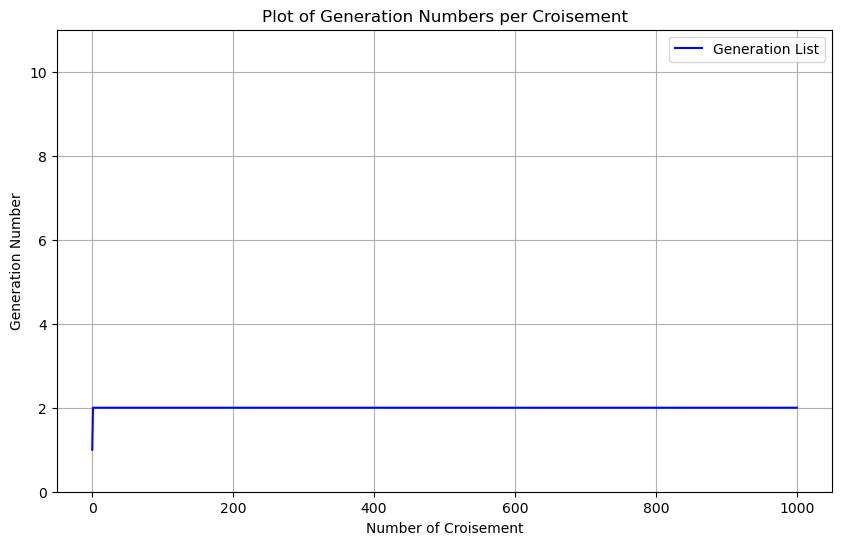

In [ ]:
plot_simlation(list_random) 

[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]


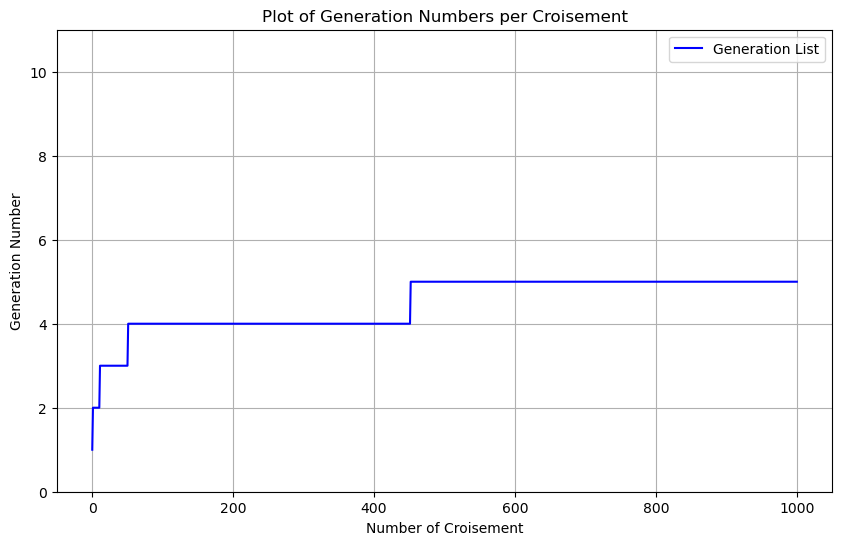

In [ ]:
plot_simlation(list_gen_upgrade_random) 

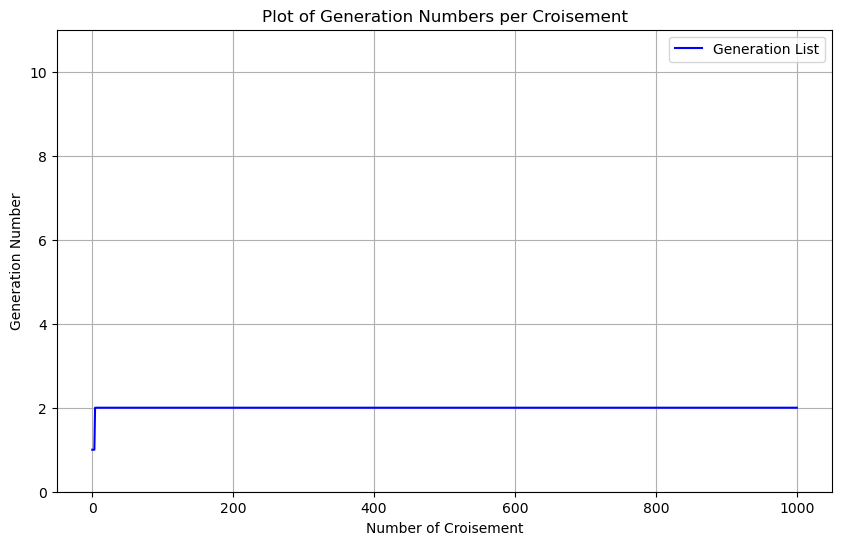

In [13]:
plot_simlation(list_select_purify)

In [ ]:
list_simulation_random = []

for i in range(100) :
    elevage = Models()
    list_gen_upgrade_random = [1]
    crosing_number = 1000
    better_generation = 1
    for i in range(crosing_number) :
        new_dd = elevage.strategy_random_crosing()
        generation = new_dd.get_generation()
        if generation > better_generation :
            better_generation = generation
        list_gen_upgrade_random.append(better_generation)
    list_simulation_random.append(list_gen_upgrade_random)

In [ ]:
list_simulation_better_gen = []

for i in range(100) :
    elevage = Models()
    list_gen_upgrade_random = [1]
    crosing_number = 1000
    better_generation = 1
    for i in range(crosing_number) :
        new_dd = elevage.strategy_crosing_better_gen()
        generation = new_dd.get_generation()
        if generation > better_generation :
            better_generation = generation
        list_gen_upgrade_random.append(better_generation)
    list_simulation_better_gen.append(list_gen_upgrade_random)

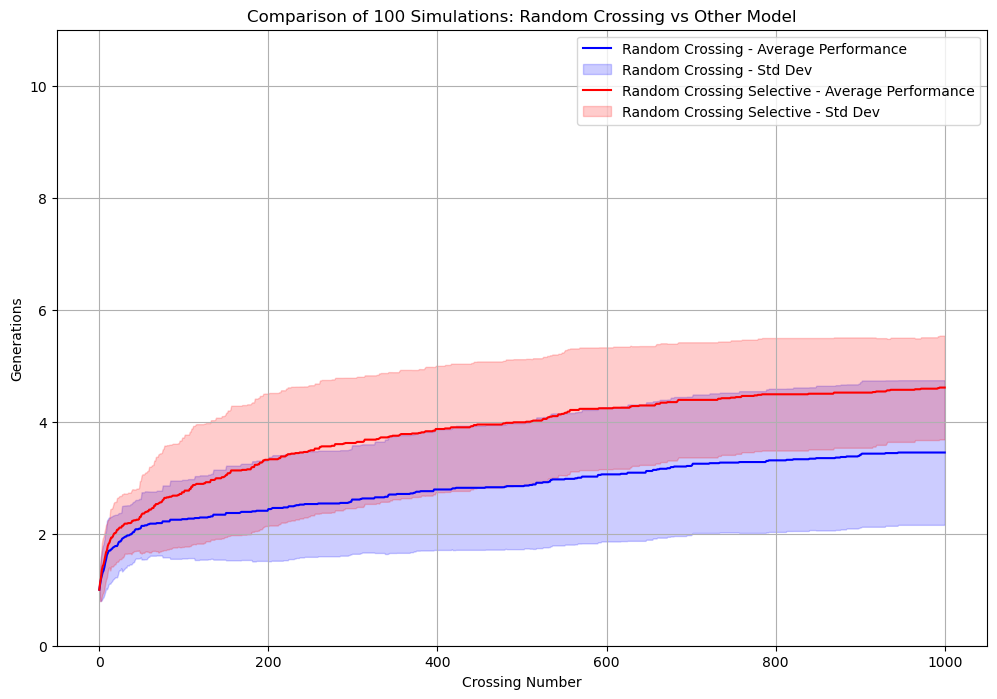

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert both to numpy arrays for easy aggregation
simulation_random_array = np.array(list_simulation_random)
simulation_other_array = np.array(list_simulation_better_gen)

# Calculate mean and standard deviation across simulations for both models
mean_performance_random = np.mean(simulation_random_array, axis=0)
std_performance_random = np.std(simulation_random_array, axis=0)

mean_performance_other = np.mean(simulation_other_array, axis=0)
std_performance_other = np.std(simulation_other_array, axis=0)

# Plotting the results
plt.figure(figsize=(12, 8))

# Plot for Random Crossing model
plt.plot(mean_performance_random, label='Random Crossing - Average Performance', color='blue')
plt.fill_between(range(crosing_number + 1), 
                 mean_performance_random - std_performance_random, 
                 mean_performance_random + std_performance_random, 
                 color='blue', alpha=0.2, label='Random Crossing - Std Dev')

# Plot for Other model
plt.plot(mean_performance_other, label='Random Crossing Selective - Average Performance', color='red')
plt.fill_between(range(crosing_number + 1), 
                 mean_performance_other - std_performance_other, 
                 mean_performance_other + std_performance_other, 
                 color='red', alpha=0.2, label='Random Crossing Selective - Std Dev')

# Customize the plot
plt.title('Comparison of 100 Simulations: Random Crossing vs Other Model')
plt.xlabel('Crossing Number')
plt.ylabel('Generations')
plt.ylim(0, 11)  # Set y-axis limits from 0 to 11
plt.legend()
plt.grid(True)
plt.show()